# Data Preprocessing

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from scipy import stats

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

import xgboost as xgb
from xgboost import plot_importance

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [6]:
# Function to load specific datasets
def load_dataset():
    # Determine the current working directory
    current_dir = os.getcwd()
    
    # Create the path to the raw_data directory relative to the current directory
    base_dir = os.path.abspath(os.path.join(current_dir, "..", "raw_data"))
    
# Define the path to the All_Airports.csv file
    all_airports_file_path = os.path.join(base_dir, "All_Airports.csv")
    
    # Load the CSV file into a DataFrame
    df = pd.read_csv(all_airports_file_path, compression='zip')
    
    return df

df = load_dataset()

In [7]:
#Inspect DF 

df.head()

,Time,Origin,Dest,Carrier,Cancelled,CancellationReason,Delayed,DepDelayMinutes,CarrierDelay,WeatherDelay,...,LateAircraftDelay,Temperature,Feels_Like_Temperature,Altimeter_Pressure,Sea_Level_Pressure,Visibility,Wind_Speed,Wind_Gust,Precipitation,Ice_Accretion_3hr
0,2021-01-01 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,False,0.0,NaN,NaN,...,NaN,56.0,55.9,1020.32,1020.1,16093.40,0.0,24.97,0.0,0.0
1,2021-01-02 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,True,2.0,NaN,NaN,...,NaN,54.0,54.0,1025.74,1025.5,16093.40,0.0,24.97,0.0,0.0
2,2021-01-03 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,True,28.0,28.0,0.0,...,0.0,52.0,52.0,1024.38,1015.2,4828.02,4.6,24.97,0.0,0.0
3,2021-01-03 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,True,28.0,28.0,0.0,...,0.0,53.0,53.1,1024.38,1024.1,6437.36,4.6,24.97,0.0,0.0
4,2021-01-04 09:00:00,LAX,JFK,American Airlines Inc.,False,NaN,False,0.0,NaN,NaN,...,NaN,51.0,51.1,1023.03,1015.2,6437.36,4.6,24.97,0.0,0.0


### Missing Values

In [8]:
#Select Numbers only
df_num = df.select_dtypes(include='number')
print(df_num.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15144514 entries, 0 to 15144513
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   DepDelayMinutes         float64
 1   CarrierDelay            float64
 2   WeatherDelay            float64
 3   NASDelay                float64
 4   SecurityDelay           float64
 5   LateAircraftDelay       float64
 6   Temperature             float64
 7   Feels_Like_Temperature  float64
 8   Altimeter_Pressure      float64
 9   Sea_Level_Pressure      float64
 10  Visibility              float64
 11  Wind_Speed              float64
 12  Wind_Gust               float64
 13  Precipitation           float64
 14  Ice_Accretion_3hr       float64
dtypes: float64(15)
memory usage: 1.7 GB
None


In [9]:
# Check Missing Values
missing_values = df.isnull().sum()

print(missing_values)

Time                             0
Origin                           0
Dest                             0
Carrier                          0
Cancelled                        0
CancellationReason        14804803
Delayed                          0
DepDelayMinutes             328891
CarrierDelay              11870186
WeatherDelay              11870186
NASDelay                  11870186
SecurityDelay             11870186
LateAircraftDelay         11870186
Temperature                      0
Feels_Like_Temperature           0
Altimeter_Pressure               0
Sea_Level_Pressure               0
Visibility                       0
Wind_Speed                       0
Wind_Gust                        0
Precipitation                    0
Ice_Accretion_3hr                0
dtype: int64


In [10]:
len(df)

15144514

In [11]:
# Display rows with missing values in 'DepDelayMinutes'
missing_dep_delay = df_num[df_num['DepDelayMinutes'].isnull()]
print(missing_dep_delay.head())

     DepDelayMinutes  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
82               NaN           NaN           NaN       NaN            NaN   
171              NaN           NaN           NaN       NaN            NaN   
172              NaN           NaN           NaN       NaN            NaN   
173              NaN           NaN           NaN       NaN            NaN   
174              NaN           NaN           NaN       NaN            NaN   

     LateAircraftDelay  Temperature  Feels_Like_Temperature  \
82                 NaN         58.0                    57.9   
171                NaN         47.0                    46.9   
172                NaN         47.0                    46.9   
173                NaN         46.0                    46.0   
174                NaN         47.0                    46.9   

     Altimeter_Pressure  Sea_Level_Pressure  Visibility  Wind_Speed  \
82              1019.30              1019.2    16093.40         0.0   
171             

#### Inspect Missing Values in all relevant columns

In [12]:
# Inspect specific columns with missing values
print(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].head(20))
print(df[['CancellationReason']].head(20))

    DepDelayMinutes  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
0               0.0           NaN           NaN       NaN            NaN   
1               2.0           NaN           NaN       NaN            NaN   
2              28.0          28.0           0.0       2.0            0.0   
3              28.0          28.0           0.0       2.0            0.0   
4               0.0           NaN           NaN       NaN            NaN   
5               0.0           NaN           NaN       NaN            NaN   
6               0.0           NaN           NaN       NaN            NaN   
7               0.0           NaN           NaN       NaN            NaN   
8               0.0           NaN           NaN       NaN            NaN   
9               0.0           NaN           NaN       NaN            NaN   
10              0.0           NaN           NaN       NaN            NaN   
11              0.0           NaN           NaN       NaN            NaN   
12          

In [13]:
# Filter and inspect rows where DepDelayMinutes is NaN
print(df[df['DepDelayMinutes'].isnull()][['DepDelayMinutes', 'Delayed', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].head(20))

# Filter and inspect rows where WeatherDelay is NaN
print(df[df['WeatherDelay'].isnull()][['DepDelayMinutes', 'Delayed', 'WeatherDelay', 'CarrierDelay', 'NASDelay']].head(20))

# Filter and inspect rows where CancellationReason is NaN
print(df[df['CancellationReason'].isnull()][['CancellationReason', 'Cancelled']].head(20))

      DepDelayMinutes  Delayed  CarrierDelay  WeatherDelay  NASDelay  \
82                NaN    False           NaN           NaN       NaN   
171               NaN    False           NaN           NaN       NaN   
172               NaN    False           NaN           NaN       NaN   
173               NaN    False           NaN           NaN       NaN   
174               NaN    False           NaN           NaN       NaN   
175               NaN    False           NaN           NaN       NaN   
487               NaN    False           NaN           NaN       NaN   
1318              NaN    False           NaN           NaN       NaN   
1418              NaN    False           NaN           NaN       NaN   
1485              NaN    False           NaN           NaN       NaN   
1778              NaN    False           NaN           NaN       NaN   
1883              NaN    False           NaN           NaN       NaN   
2100              NaN    False           NaN           NaN      

In [14]:
# # Visualize missing data in the delay columns
# plt.figure(figsize=(10, 6))
# sns.heatmap(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']].isnull(), cbar=False, cmap='viridis')
# plt.title('Missing Data in Delay Columns')
# plt.show()

### Data Imputation for NaN

In [15]:
# Impute NaN in delay columns with 0.0
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
df[delay_columns] = df[delay_columns].fillna(0.0)

In [16]:
# Impute NaN in DepDelayMinutes with 0.0
df['DepDelayMinutes'] = df['DepDelayMinutes'].fillna(0.0)

In [17]:
# Impute NaN in CancellationReason with 'Not Cancelled'
df['CancellationReason'] = df['CancellationReason'].fillna('Not Cancelled')

In [18]:
# Display the first few rows after imputation to confirm changes
print(df[['DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'CancellationReason']].head(20))

    DepDelayMinutes  CarrierDelay  WeatherDelay  NASDelay  SecurityDelay  \
0               0.0           0.0           0.0       0.0            0.0   
1               2.0           0.0           0.0       0.0            0.0   
2              28.0          28.0           0.0       2.0            0.0   
3              28.0          28.0           0.0       2.0            0.0   
4               0.0           0.0           0.0       0.0            0.0   
5               0.0           0.0           0.0       0.0            0.0   
6               0.0           0.0           0.0       0.0            0.0   
7               0.0           0.0           0.0       0.0            0.0   
8               0.0           0.0           0.0       0.0            0.0   
9               0.0           0.0           0.0       0.0            0.0   
10              0.0           0.0           0.0       0.0            0.0   
11              0.0           0.0           0.0       0.0            0.0   
12          

### Handling Outliers

In [19]:
# Identify outliers using Z-score
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
outliers = np.where(z_scores > 3)
print(f"Outliers found: {len(outliers[0])}")

Outliers found: 1881233


In [20]:
# # Visualize outliers in specific columns
# for column in df.select_dtypes(include=[np.number]).columns:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=df[column])
#     plt.title(f'Boxplot of {column}')
#     plt.show()

### Manually Inspecting Extreme Outliers

In [21]:
# Define a function to identify and print extreme outliers for a given feature
def inspect_outliers(df, feature):
    # Calculate the Interquartile Range (IQR)
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier criteria: below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify extreme outliers
    extreme_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    # Print information about the outliers
    print(f"Feature: {feature}")
    print(f"Lower Bound: {lower_bound}")
    print(f"Upper Bound: {upper_bound}")
    print(f"Number of Extreme Outliers: {len(extreme_outliers)}")
    print(extreme_outliers[[feature]].head(20))  # Show top 20 outliers for inspection
    print("\n" + "-"*80 + "\n")

# List of features for which to inspect outliers
features_to_inspect = [
    'DepDelayMinutes', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 
    'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature', 'Altimeter_Pressure', 
    'Sea_Level_Pressure', 'Visibility', 'Wind_Speed', 'Wind_Gust', 
    'Precipitation', 'Ice_Accretion_3hr'
]

# Loop through each feature and inspect outliers
for feature in features_to_inspect:
    inspect_outliers(df, feature)

Feature: DepDelayMinutes
Lower Bound: -15.0
Upper Bound: 25.0
Number of Extreme Outliers: 2333489
     DepDelayMinutes
2               28.0
3               28.0
38              76.0
46              34.0
69              87.0
70              87.0
76              34.0
112            265.0
113            265.0
127             44.0
133            390.0
153             35.0
242             40.0
243             40.0
290             30.0
303             42.0
304             42.0
342             72.0
366             40.0
395            355.0

--------------------------------------------------------------------------------

Feature: CarrierDelay
Lower Bound: 0.0
Upper Bound: 0.0
Number of Extreme Outliers: 1925686
     CarrierDelay
2            28.0
3            28.0
38           59.0
46           31.0
54            9.0
112         265.0
113         265.0
127          37.0
133         390.0
153          35.0
177          14.0
181          20.0
236           2.0
242          23.0
243          23.

### Manually Treating Extreme Outliers

In [22]:
# Departure Delay Minutes
df['DepDelayMinutes'] = np.clip(df['DepDelayMinutes'], -15.0, 25.0)

In [23]:
# Carrier Delay
df['CarrierDelay'] = np.clip(df['CarrierDelay'], 0.0, 390.0)

In [24]:
#Weather Delay
df['WeatherDelay'] = np.clip(df['WeatherDelay'], 0.0, 140.0)

In [25]:
#NASDelay
df['NASDelay'] = np.clip(df['NASDelay'], 0.0, 247.0)

In [26]:
#Security Delay
df['SecurityDelay'] = np.clip(df['SecurityDelay'], 0.0, 146.0)

In [27]:
#LateAircraft Delay
df['LateAircraftDelay'] = np.clip(df['LateAircraftDelay'], 0.0, 111.0)

In [28]:
#Temperature
df['Temperature'] = np.clip(df['Temperature'], 13.5, 113.5)

In [29]:
#Feels_Like_Temperature
df['Feels_Like_Temperature'] = np.clip(df['Feels_Like_Temperature'], 13.75, 113.35)

In [30]:
#Altimeter Pressure
df['Altimeter_Pressure'] = np.clip(df['Altimeter_Pressure'], 1000.8449999999998, 1032.005)

In [31]:
#Sea_Level_Pressure
df['Sea_Level_Pressure'] = np.clip(df['Sea_Level_Pressure'], 1003.05, 1029.05)

In [32]:
#Visibility
df['Visibility'] = df['Visibility'].clip(lower=0, upper=16093.4)

In [33]:
#Wind Speed
df['Wind_Speed'] = np.clip(df['Wind_Speed'], 0.0, 23.025)

In [34]:
#Wind Gust
df['Wind_Gust'] = np.clip(df['Wind_Gust'], 20.42, 31.94)


In [35]:
#Precipitation
df['Precipitation'] = np.clip(df['Precipitation'], 0.0, 5.59)

In [36]:
#Ice Accretion
df['Ice_Accretion_3hr'] = np.clip(df['Ice_Accretion_3hr'], 0.0, 1.78)

In [37]:
# # Identify outliers using Z-score
# z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
# outliers = np.where(z_scores > 3)
# print(f"Outliers found: {len(outliers[0])}")

# # Visualize outliers in specific columns
# for column in df.select_dtypes(include=[np.number]).columns:
#     plt.figure(figsize=(10, 6))
#     sns.boxplot(x=df[column])
#     plt.title(f'Boxplot of {column}')
#     plt.show()

#### Outliers Summary

After removing extreme outliets, a total of 1,954,889 outliers were kept. This means approximately 12.9% of our data points are classified as outliers using this method.
Given the size of our dataset, a large number of outliers might be expected, especially in a dataset with a variety of delay types and weather conditions.

### Clean Column Names to create a categorical y_pred before creating Train/Test Split

In [38]:
# Check the datatype of the 'Time' column
print(f"Data type of 'Time': {df['Time'].dtype}")

# If not datetime, convert it to datetime
if not pd.api.types.is_datetime64_any_dtype(df['Time']):
    df['Time'] = pd.to_datetime(df['Time'])
    print(f"After conversion, Data type of 'Time': {df['Time'].dtype}")

Data type of 'Time': object
After conversion, Data type of 'Time': datetime64[ns]


In [39]:
# Extract hour, day of the week, and month from the Time column
df['Hour'] = df['Time'].dt.hour
df['Day_Of_Week'] = df['Time'].dt.dayofweek
df['Month'] = df['Time'].dt.month

In [40]:
# Rename the 'WeatherDelay' column to 'Weather_Delay_Length' for clarity before we create a new 'Binary' column
df.rename(columns={'WeatherDelay': 'Weather_Delay_Length'}, inplace=True)

# Verify the change
print(df.columns)

Index(['Time', 'Origin', 'Dest', 'Carrier', 'Cancelled', 'CancellationReason',
       'Delayed', 'DepDelayMinutes', 'CarrierDelay', 'Weather_Delay_Length',
       'NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Temperature',
       'Feels_Like_Temperature', 'Altimeter_Pressure', 'Sea_Level_Pressure',
       'Visibility', 'Wind_Speed', 'Wind_Gust', 'Precipitation',
       'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month'],
      dtype='object')


In [41]:

# Create a new binary column 'WeatherDelay_Binary'
df['Weather_Delayed'] = df['Weather_Delay_Length'].apply(lambda x: 1 if x > 0 else 0)

# Check the first few rows to confirm
print(df[['Weather_Delay_Length', 'Weather_Delayed']].head(10))


   Weather_Delay_Length  Weather_Delayed
0                   0.0                0
1                   0.0                0
2                   0.0                0
3                   0.0                0
4                   0.0                0
5                   0.0                0
6                   0.0                0
7                   0.0                0
8                   0.0                0
9                   0.0                0


In [42]:

# Calculate the total number of instances
total = df['Weather_Delayed'].count()

# Calculate the percentage of each class
percent_delayed = (df['Weather_Delayed'].value_counts()[1] / total) * 100
percent_not_delayed = (df['Weather_Delayed'].value_counts()[0] / total) * 100

# Display the results
print(f"Percentage of delayed flights: {percent_delayed:.2f}%")
print(f"Percentage of not delayed flights: {percent_not_delayed:.2f}%")


Percentage of delayed flights: 1.82%
Percentage of not delayed flights: 98.18%


## Save preprocessed file before test/split and Scaling

In [43]:

# Function to save the DataFrame to the raw_data directory
def save_dataset(df):
    # Determine the current working directory
    current_dir = os.getcwd()
    
    # Create the path to the raw_data directory relative to the current directory
    base_dir = os.path.abspath(os.path.join(current_dir, "..", "data"))
    
    # Define the path to save the treated outliers DataFrame
    treated_outliers_file_path = os.path.join(base_dir, "preprocessed_treated_outliers.csv")
    
    # Save the DataFrame as a CSV file
    df.to_csv(treated_outliers_file_path, index=False)
    
# Call the function to save your DataFrame
save_dataset(df)

## Load preprocessed data

In [4]:
# Load preprocessed data set from /data folder
current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(current_dir, "..", "data"))
file_path = os.path.join(base_dir, "preprocessed_treated_outliers.csv")
    
preprocessed_df = pd.read_csv(file_path)

print(preprocessed_df.head())

                  Time Origin Dest                 Carrier  Cancelled  \
0  2021-01-01 09:00:00    LAX  JFK  American Airlines Inc.      False   
1  2021-01-02 09:00:00    LAX  JFK  American Airlines Inc.      False   
2  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
3  2021-01-03 09:00:00    LAX  JFK  American Airlines Inc.      False   
4  2021-01-04 09:00:00    LAX  JFK  American Airlines Inc.      False   

  CancellationReason  Delayed  DepDelayMinutes  CarrierDelay  \
0      Not Cancelled    False              0.0           0.0   
1      Not Cancelled     True              2.0           0.0   
2      Not Cancelled     True             25.0          28.0   
3      Not Cancelled     True             25.0          28.0   
4      Not Cancelled    False              0.0           0.0   

   Weather_Delay_Length  ...  Sea_Level_Pressure  Visibility  Wind_Speed  \
0                   0.0  ...              1020.1    16093.40         0.0   
1                   0.0 

In [5]:
# Define y_pred and drop 'Weather_Delay_Length' to avoid data leakage
X = preprocessed_df.drop(columns=['Delayed'])
y = preprocessed_df['Delayed']

In [6]:
#Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# XGBoost small sample test

In [7]:
# Sample only 10% of the data for quick testing
X_sample, _, y_sample, _ = train_test_split(
    X, y, 
    test_size=0.9,  # Keep only 10% for the sample
    random_state=42, 
    stratify=y  # Maintain the class distribution
)

In [8]:
# Split the sampled data into train and test sets
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
    X_sample, y_sample, 
    test_size=0.2,  # 80% train, 20% test
    random_state=42, #Reproducibility
    stratify=y_sample  # Maintain the class distribution in the split
)

In [9]:
# Identify categorical, binary, and numeric features
categorical_features = ['CancellationReason', 'Origin', 'Dest', 'Carrier']
binary_features = ['Cancelled']
numeric_features = ['DepDelayMinutes', 'CarrierDelay', 'NASDelay',
                    'SecurityDelay', 'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature',
                    'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
                    'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month']

# One-hot encode categorical features
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train_sample[categorical_features])
X_test_encoded = encoder.transform(X_test_sample[categorical_features])

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sample[numeric_features])
X_test_scaled = scaler.transform(X_test_sample[numeric_features])


### PCA Analysis

In [10]:
#Assing PCA and number of components
pca = PCA(n_components=3)

#Apply PCA to scaled numeric features
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [11]:
#Concatenate arrays to form one array
X_train_preprocessed = np.hstack([X_train_encoded.toarray(), X_train_pca, X_train_sample[binary_features]])
X_test_preprocessed = np.hstack([X_test_encoded.toarray(), X_test_pca, X_test_sample[binary_features]])

In [12]:
# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_preprocessed, y_train_sample)

In [273]:
# #Define Param Grid
# param_grid = {
#     'reg_alpha': [0, 0.5],  # L1
#     'reg_lambda': [0, 0.5],  # L2
#     'max_depth': [5, 10],  # Tree depth
#     'n_estimators': [100, 200]  # Boosting rounds
# }

In [13]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    use_label_encoder=False,  # Disable the use of the label encoder - Need to test if this is required or not
    eval_metric='logloss',  # logloss as the evaluation metric
    random_state=42,  # For reproducibility
)

In [275]:
# #Grid Search
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='recall', cv=3, n_jobs=-1)

In [276]:
# #Fit Grid Search on balanced training data
# grid_search.fit(X_train_balanced, y_train_balanced)

/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:32:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:32:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:32:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:32:35] WARNING: /Users

In [ ]:
# #Print the best parameters and score
# print(f"Best Parameters from Grid Search: {grid_search.best_params_}")
# print(f"Best F1 Score from Grid Search: {grid_search.best_score_}")

In [14]:
# Fit the model on the balanced training data
xgb_model.fit(X_train_balanced, y_train_balanced)

/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [11:49:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

###### Note: Need to investigate "use_label_encoder" error

In [15]:
# Evaluate the model on the test data
y_pred = xgb_model.predict(X_test_preprocessed)

In [16]:
# Calculate F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test_sample, y_pred)
print(f"F1 Score on the test set: {f1}")

F1 Score on the test set: 0.8482068096283173


In [17]:
#Calculate Recall
from sklearn.metrics import recall_score
recall = recall_score(y_test_sample, y_pred)
print(f"Recall: {recall}")

Recall: 0.8161802746185618


In [18]:
# Calculate ROC AUC
from sklearn.metrics import roc_auc_score
auc_roc = roc_auc_score(y_test_sample, y_pred)
print(f"AUC-ROC: {auc_roc}")

AUC-ROC: 0.8735732653974192


In [19]:
# Inspect Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_sample, y_pred)
print(f"Confusion Matrix:\n{cm}")

Confusion Matrix:
[[172212  12770]
 [ 21674  96235]]


In [20]:
# Generate Classifiation Report
from sklearn.metrics import classification_report
report = classification_report(y_test_sample, y_pred)
print(f"Classification Report:\n{report}")

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.93      0.91    184982
        True       0.88      0.82      0.85    117909

    accuracy                           0.89    302891
   macro avg       0.89      0.87      0.88    302891
weighted avg       0.89      0.89      0.89    302891



#### Plot Feature Importance

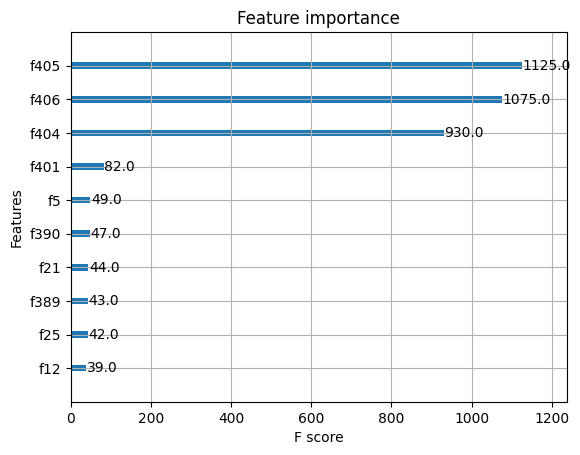

In [21]:
# Plot the feature importance
plot_importance(xgb_model, max_num_features=10)
plt.show()

In [22]:
# Get the feature names from the encoder
encoded_feature_names = encoder.get_feature_names_out(categorical_features)

In [23]:
# Combine feature names
all_feature_names = np.hstack([
    encoded_feature_names,  # Encoded categorical feature names
    numeric_features,        # Numeric feature names
    binary_features          # Binary feature names
])

In [24]:
# Mapping indices to feature names
important_features = [(all_feature_names[i], importance) for i, importance in enumerate(xgb_model.feature_importances_)]

# Sort by importance
important_features.sort(key=lambda x: x[1], reverse=True)

# Display top important features
for feature, importance in important_features[:30]:
    print(f"Feature: {feature}, Importance: {importance}")

Feature: NASDelay, Importance: 0.09637004137039185
Feature: CancellationReason_Not Cancelled, Importance: 0.09510008990764618
Feature: Carrier_Southwest Airlines Co., Importance: 0.06344545632600784
Feature: CarrierDelay, Importance: 0.045748021453619
Feature: Carrier_Republic Airline, Importance: 0.0338265486061573
Feature: Carrier_Endeavor Air Inc., Importance: 0.03343186527490616
Feature: DepDelayMinutes, Importance: 0.027926653623580933
Feature: Carrier_SkyWest Airlines Inc., Importance: 0.018977416679263115
Feature: Origin_DEN, Importance: 0.017800258472561836
Feature: Carrier_Envoy Air, Importance: 0.016140513122081757
Feature: Carrier_PSA Airlines Inc., Importance: 0.014386934228241444
Feature: Dest_HNL, Importance: 0.012739724479615688
Feature: Dest_ATL, Importance: 0.011910599656403065
Feature: Origin_PHX, Importance: 0.008513613604009151
Feature: Carrier_United Air Lines Inc., Importance: 0.008288179524242878
Feature: Dest_DSM, Importance: 0.007207417860627174
Feature: Dest_M

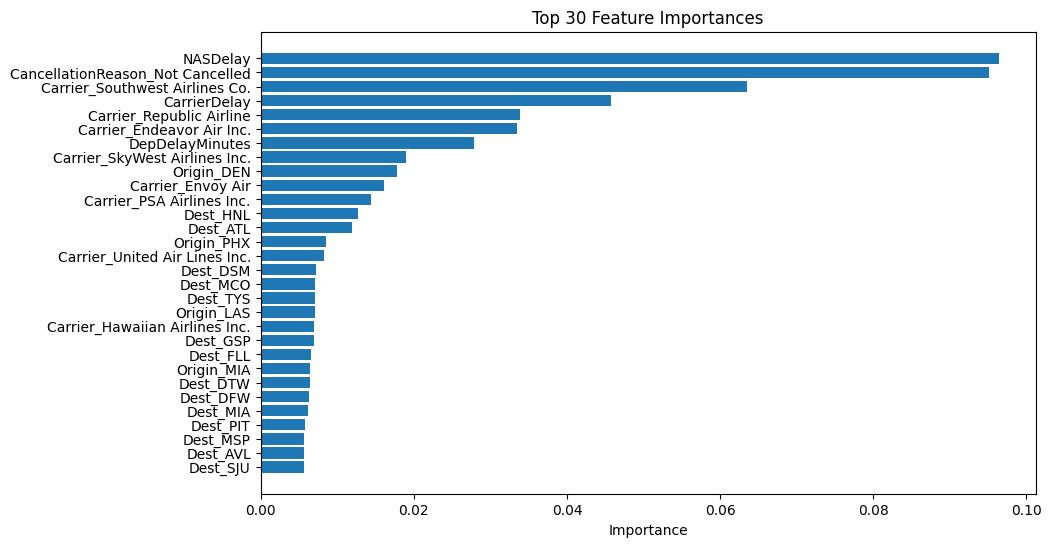

In [25]:
# Sort the important features by importance
important_features.sort(key=lambda x: x[1], reverse=True)

# Extract the top 10 features and their importance
top_features = important_features[:30]
features = [f[0] for f in top_features]
importances = [f[1] for f in top_features]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances)
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis() 
plt.show()

# XGBoost

## Preprocessing Pipelines

In [47]:
# # Define categorical, binary, and numeric features
# categorical_features = ['CancellationReason', 'Origin', 'Dest', 'Carrier']
# binary_features = ['Cancelled', 'Delayed']
# numeric_features = ['DepDelayMinutes', 'CarrierDelay', 'NASDelay',
#                     'SecurityDelay', 'LateAircraftDelay', 'Temperature', 'Feels_Like_Temperature',
#                     'Altimeter_Pressure', 'Sea_Level_Pressure', 'Visibility', 'Wind_Speed',
#                     'Wind_Gust', 'Precipitation', 'Ice_Accretion_3hr', 'Hour', 'Day_Of_Week', 'Month']

# # Define the preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('onehot', OneHotEncoder(), categorical_features),  # Encode categorical features
#         ('passthrough_binary', 'passthrough', binary_features),  # Pass binary features as is
#         ('passthrough_numeric', 'passthrough', numeric_features)  # Pass numeric features as is
#     ],
#     remainder='drop'  # Drop the Time column and any other unspecified features
# )

## Scaling, Balacing & Modeling with Pipelines

### StandardScaler + SMOTE Pipeline

In [48]:
# # Pipeline with StandardScaler and SMOTE, with XGBClassifier model
# pipeline_ss_smote = ImbPipeline([
#     ('preprocessor', preprocessor), #Preprocessor
#     ('scaler', StandardScaler(with_mean=False)),  # Standard Scaler for normalising features
#     ('sampling', SMOTE(random_state=42)),  # SMOTE for oversampling the minority class
# ])

In [49]:
# # Grid Search parameters for Standard Scaler + SMOTE + XGBoost
# param_grid_ss_smote = {
#     'classifier__n_estimators': [100],  # Number of boosting rounds
#     'classifier__max_depth': [5]  # Maximum depth of the trees
# }

In [50]:
# # Cross-validation strategy
# cv = StratifiedKFold(n_splits=5)

In [51]:
# #Small X_train sample for local testing
# X_train_sample, _, y_train_sample, _ = train_test_split(
#     X_train, y_train, 
#     test_size=0.9,  # Keep only 10% for the sample
#     random_state=42
# )

In [55]:
# X_train_sample

,Time,Origin,Dest,Carrier,Cancelled,CancellationReason,Delayed,DepDelayMinutes,CarrierDelay,NASDelay,...,Altimeter_Pressure,Sea_Level_Pressure,Visibility,Wind_Speed,Wind_Gust,Precipitation,Ice_Accretion_3hr,Hour,Day_Of_Week,Month
3197103,2023-09-18 20:00:00,TPA,HOU,Southwest Airlines Co.,False,Not Cancelled,False,0.0,0.0,0.0,...,1013.21,1013.0,16093.40,10.36,23.48,0.00,0.0,20,0,9
8346770,2023-07-13 12:00:00,MCO,PHL,Spirit Air Lines,False,Not Cancelled,False,0.0,0.0,0.0,...,1016.93,1016.6,16093.40,8.06,26.70,0.00,0.0,12,3,7
7776437,2023-02-15 18:00:00,JFK,AUS,Delta Air Lines Inc.,False,Not Cancelled,False,0.0,0.0,0.0,...,1012.87,1012.7,16093.40,12.66,29.23,0.00,0.0,18,2,2
902402,2022-11-28 14:00:00,LAX,LAS,JetBlue Airways,False,Not Cancelled,False,0.0,0.0,0.0,...,1012.87,1012.6,11265.38,12.66,24.97,0.00,0.0,14,0,11
12945960,2022-01-04 08:00:00,BNA,ECP,Southwest Airlines Co.,False,Not Cancelled,True,25.0,32.0,0.0,...,1026.75,1027.1,8046.70,5.75,24.51,0.00,0.0,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7121396,2022-02-21 07:00:00,CLT,ATL,Delta Air Lines Inc.,False,Not Cancelled,False,0.0,0.0,0.0,...,1028.11,1018.1,16093.40,3.45,23.36,0.00,0.0,7,0,2
5447099,2023-08-12 19:00:00,IAH,DFW,United Air Lines Inc.,False,Not Cancelled,False,0.0,0.0,0.0,...,1011.51,1011.4,16093.40,13.81,21.86,0.00,0.0,19,5,8
3684468,2022-04-12 09:00:00,DFW,FLL,American Airlines Inc.,False,Not Cancelled,False,0.0,0.0,0.0,...,1006.77,1005.7,14484.06,17.26,28.77,0.00,0.0,9,1,4
11731622,2022-02-05 18:00:00,PHX,COS,Southwest Airlines Co.,False,Not Cancelled,True,17.0,0.0,0.0,...,1018.63,1018.0,16093.40,0.00,24.51,0.00,0.0,18,5,2


In [52]:
# # Running GridSearch
# grid_search_ss_smote_sample = GridSearchCV(pipeline_ss_smote, param_grid_ss_smote, cv=cv, scoring='f1', n_jobs=-1)

In [53]:
# #Fit X_train_sample and y_train_sample
# grid_search_ss_smote_sample.fit(X_train_sample, y_train_sample)

/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:09:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:09:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:09:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/diego_mogollon/.pyenv/versions/3.10.6/envs/lateguru/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:09:09] WARNING: /Users

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['CancellationReason',
                                                                          'Origin',
                                                                          'Dest',
                                                                          'Carrier']),
                                                                        ('passthrough_binary',
                                                                         'passthrough',
                                                                         ['Cancelled',
                                                                          'Delayed']),
                                                                        ('passthrough_numeric',
                                                                         'passthrough',
                                                                         ['DepDelayMinutes',
                                                                          'Carrie...
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [5],
                         'classifier__n_estimators': [100]},
             scoring='f1')

In [54]:
# # Store results
# best_model_ss_smote = grid_search_ss_smote_sample.best_estimator_
# print(f"Best Parameters for SS + SMOTE: {grid_search_ss_smote_sample.best_params_}")
# print(f"Best F1 Score from Sample Grid Search: {grid_search_ss_smote_sample.best_score_}")

Best Parameters for SS + SMOTE: {'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best F1 Score from Sample Grid Search: nan
